В этом задании вам предстоит использовать данные о выживаемости на Титанике для построения модели бинарной классификации для признака Survived.

Считайте датасет из файла train.csv (это данные о выживаемости на Титанике)

Выберите и обоснуйте метрику для измерения качества (accuracy/precision/recall/f1-score/fbeta-score/roc-auc и т.д.). В рамках данного пункта необходимо подобрать наиболее релевантную метрику или набор метрик для вашей задачи, написав краткое обоснование (1-2 предложения) - 2 балла +

Постройте бейзлайн и ML-модель классификации (LogisticRegression или любая другая, которая вам кажется подходящей) и оцените их качество с помощью выбранной метрики

Критерии оценки:

- Произведено разбиение датасета на тренировочную/тестовую выборки - 1 балл +

- Произведено измерение качества константного предсказания (например, наиболее частотный класс/случайное предсказание) - 1 балл +

- ML-модель обучена на тренировочной выборке, учтены особенности предобработки данных для модели, если они есть - 3 балла +

- Произведено измерение качества на отложенной выборке с использованием ранее выбранной метрики - 1 балл +

- Обеспечена воспроизводимость решения: зафиксированы random_state, ноутбук воспроизводится от начала до конца без ошибок - 2 балла +

In [30]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/MyDrive/'
/content/drive/MyDrive


In [31]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

df = pd.read_csv("train.csv")
df["Survived"].value_counts()
#df.info()

,count
Survived,
0,549
1,342


Так как предстоит решить задачу классификации и по признаку Survived в наборе данных не наблюдается большого дисбаланса (342 против 549), то можно использовать стандартные метрики оценки качества, такие как Accuracy. Однако, более релевантной видятся более точные метрики, например, F1-score.

In [32]:
#Применяем кодировки для категориальных данных в столбцах "Sex" и "Embarked"

from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
res = ohe.fit_transform(df['Sex'].to_numpy().reshape(-1, 1))
ohe_df = pd.DataFrame(res.toarray(), columns=ohe.get_feature_names_out())
res = pd.get_dummies(df['Sex'], drop_first=True)

df = pd.concat([df, res], axis=1).drop(columns='Sex')

res = ohe.fit_transform(df['Embarked'].to_numpy().reshape(-1, 1))
ohe_df = pd.DataFrame(res.toarray(), columns=ohe.get_feature_names_out())
res = pd.get_dummies(df['Embarked'], drop_first=True)

df = pd.concat([df, res], axis=1).drop(columns='Embarked')
df.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,male,Q,S
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,True,False,True
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,False,False,False
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,False,False,True
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,False,False,True
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,True,False,True


In [33]:
#Удаляем столбцы с текстовыми данными
df1 = df.drop(["Name", "Ticket", "Cabin"], axis=1)

In [34]:
# Убираем строки с пустыми значениями
df2 = df1.dropna()

<Axes: >

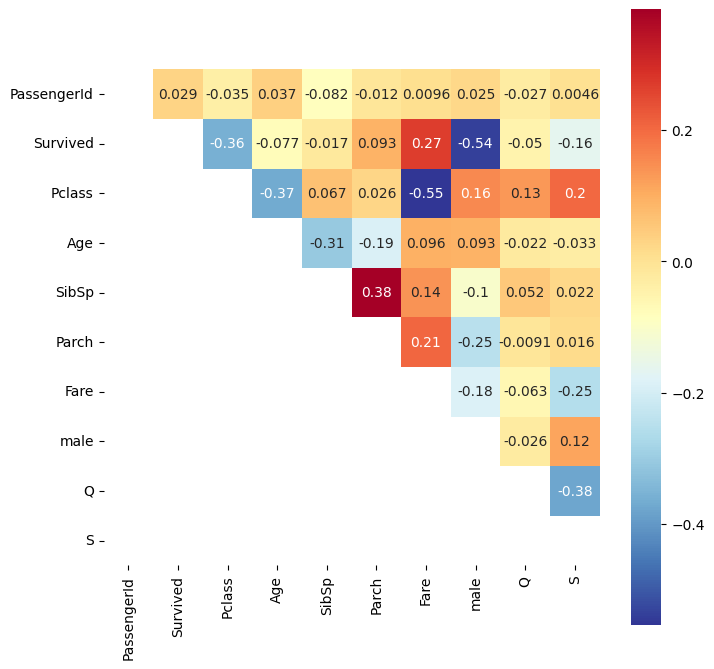

In [35]:
#Проверяем мультиколлинеарность

corrs = df2.corr()
upper_tri = corrs.where(np.triu(np.ones(corrs.shape), k=1).astype(np.bool_))
upper_tri

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 8))
sns.heatmap(upper_tri, cmap="RdYlBu_r", square=True, annot=True)

В датасете практически нет данных, которые бы сильно коррелировали друг с другом

In [36]:
#Разбиваем и масштабируем данные

from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler

y = df2["Survived"]
X = df2[["Pclass", "Age", "SibSp", "Parch", "Fare", "male", "Q", "S"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2024, test_size=0.25, stratify=y)
X_train.info()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
log_reg = LogisticRegression()
cross_val_score(log_reg, X_train_scaled, y_train, cv=10, scoring='f1')

<class 'pandas.core.frame.DataFrame'>
Index: 535 entries, 170 to 404
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Pclass  535 non-null    int64  
 1   Age     535 non-null    float64
 2   SibSp   535 non-null    int64  
 3   Parch   535 non-null    int64  
 4   Fare    535 non-null    float64
 5   male    535 non-null    bool   
 6   Q       535 non-null    bool   
 7   S       535 non-null    bool   
dtypes: bool(3), float64(2), int64(3)
memory usage: 26.6 KB


array([0.60465116, 0.82608696, 0.8       , 0.7       , 0.76190476,
       0.76923077, 0.74418605, 0.72727273, 0.76923077, 0.63414634])

In [37]:
# Определяем бейзлайн-модель и сравниваем с логистической регрессией при помощи метрики accuracy

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

from sklearn.metrics import accuracy_score

y_pred_dummy = dummy_clf.predict(X_test)
print (accuracy_score(y_test, y_pred_dummy))

y_pred_log_reg = log_reg.predict(X_test)
print (accuracy_score(y_test, y_pred_log_reg))

0.5921787709497207
0.7988826815642458


In [38]:
# Также проводим сравнение метрикой F1-score

from sklearn.metrics import f1_score, fbeta_score
print(f'F1-score for Dummy Classificator: {f1_score(y_test, y_pred_dummy)}')
print(f'F1-score for Logistic regression: {f1_score(y_test, y_pred_log_reg)}')

F1-score for Dummy Classificator: 0.0
F1-score for Logistic regression: 0.7352941176470589


Хоть предсказательная сила модели всё ещё невелика (~75%) это гораздо выше, чем у безлайн-модели.

In [55]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns
)

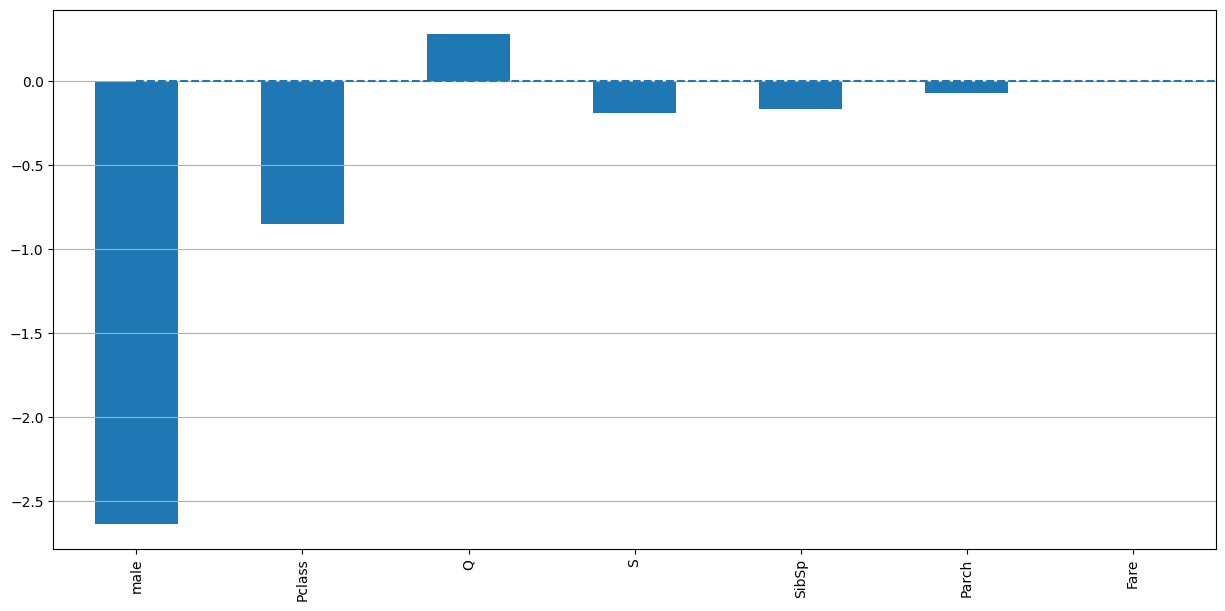

In [56]:
def plotCoefficients(model, columns):
    a = model.coef_
    coefs = pd.DataFrame(a[0], columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)

    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed')

plotCoefficients(log_reg, X_train_scaled.columns)

Видно, что модель предает наибольший вес параметру "Sex", который в нашем случае обозначен "male". В целом, это логично вытекает из предыдущего опыта работы с этим набором данных.

Так как параметр Age не сильно влияет на предсказательную силу, можно попытаться дополнительно увеличить точность модели, включив те данные, которые были удалены в ходе предобработки не включая столбец Age, так как в нем есть пропуски.

In [57]:
y = df["Survived"]
X = df[["male", "Pclass", "SibSp", "Parch", "Fare", "Q", "S"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2024, test_size=0.25, stratify=y)
X_train.info()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
log_reg = LogisticRegression()
print (cross_val_score(log_reg, X_train_scaled, y_train, cv=5, scoring='f1').mean())

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 668 entries, 114 to 205
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   male    668 non-null    bool   
 1   Pclass  668 non-null    int64  
 2   SibSp   668 non-null    int64  
 3   Parch   668 non-null    int64  
 4   Fare    668 non-null    float64
 5   Q       668 non-null    bool   
 6   S       668 non-null    bool   
dtypes: bool(3), float64(1), int64(3)
memory usage: 28.1 KB
0.7104764403827183
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7  

In [58]:
y_pred_dummy = dummy_clf.predict(X_test)
print (accuracy_score(y_test, y_pred_dummy))

log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)
print (accuracy_score(y_test, y_pred_log_reg))

0.6143497757847534
0.7757847533632287


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [59]:
print(f'F1-score for Dummy Classificator: {f1_score(y_test, y_pred_dummy)}')
print(f'F1-score for Logistic regression: {f1_score(y_test, y_pred_log_reg)}')

F1-score for Dummy Classificator: 0.0
F1-score for Logistic regression: 0.6987951807228916


Значительно увеличить предсказательную силу модели за счёт включения небольшого набора новых данных не удалось, что быть связано как с особенностями данных, так и с особенностями логистической регрессии, возможно, другая модель могла справиться лучше.

In [60]:
#Попробуем реализовать пайплайн

from sklearn.pipeline import Pipeline

pipe = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('log_reg', LogisticRegression())
        ]
    )

pipe.fit(X_train, y_train).score(X_test, y_test)

0.7802690582959642